In [3]:
!pip install livelossplot
import pandas as pd
import cv2
from matplotlib import pyplot as plt
import seaborn as sns
import os
%matplotlib inline
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from IPython.display import SVG, Image
from livelossplot import PlotLossesKeras
from tensorflow.keras.models import model_from_json
import numpy as np
import tensorflow as tf


In [2]:
# Chemin d'accès aux données
train_data_dir   = 'dataset/train/'
test_data_dir    = 'dataset/test/'

In [3]:
#Compter le nombre d'expressions faciales d'un chemin et mettre le résultat dans un dataframe
def count_face_exp(path, set_name):
    set_dict = {}
    for expression in os.listdir(path):
        set_dict[expression] = len(os.listdir(path + expression))
    df = pd.DataFrame(set_dict, index=[set_name])
    return df

In [4]:
# Compter les images par catégories d'émotions
train_count = count_face_exp(train_data_dir, 'trainset')
test_count  = count_face_exp(test_data_dir, 'testset')
print(train_count.transpose())
print(test_count.transpose())

          trainset
angry         3995
disgust        436
fear          4097
happy         7215
neutral       4965
sad           4830
surprise      3171
          testset
angry         958
disgust       111
fear         1024
happy        1774
neutral      1233
sad          1247
surprise      831


In [5]:
# Afficher quelques images par catégories d'émotion
def plot_imgs(item_dir, top = 10):
    all_item_dirs = os.listdir(item_dir)
    item_files    = [os.path.join(item_dir, file) for file in all_item_dirs][:4]
    plt.figure(figsize = (10, 10))
    for idx, img_path in enumerate(item_files):
        plt.subplot(5, 5, idx + 1)
    
        img = plt.imread(img_path)
        plt.tight_layout()         
        plt.imshow(img, cmap = 'gray')

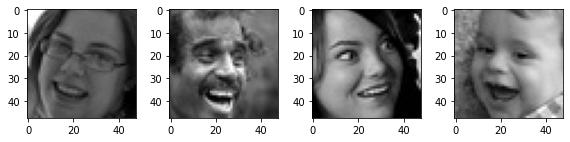

In [6]:
plot_imgs(train_data_dir + 'happy')

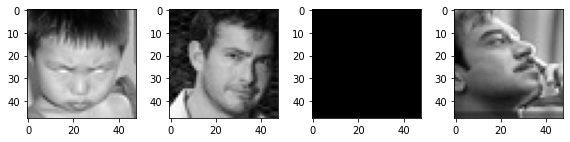

In [7]:
plot_imgs(train_data_dir + 'angry')

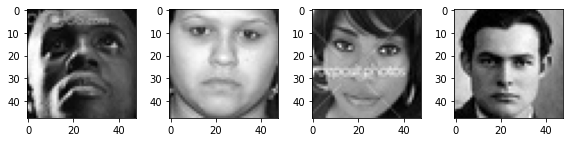

In [8]:
plot_imgs(train_data_dir + 'neutral')

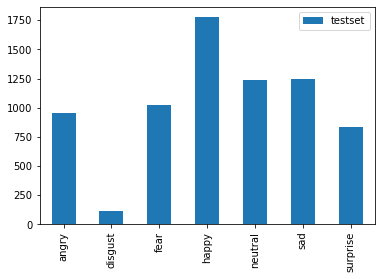

In [9]:

test_count.transpose().plot(kind = 'bar')

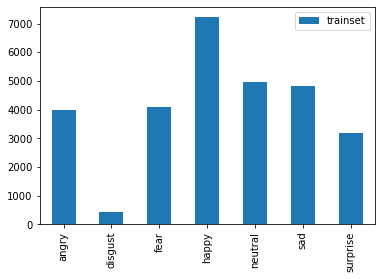

In [10]:
# Plotting training data dist
train_count.transpose().plot(kind = 'bar')

In [11]:
# Générer les données pour faire la data augmentation
img_size = 48
batch_size = 64 
datagen_train = ImageDataGenerator(horizontal_flip=True)
train_generator = datagen_train.flow_from_directory(
    "dataset/train/",
    target_size = (img_size, img_size),
    color_mode = 'grayscale',
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True
)

datagen_validation = ImageDataGenerator(horizontal_flip=True)
validation_generator = datagen_validation.flow_from_directory(
    "dataset/test/",
    target_size = (img_size, img_size),
    color_mode = 'grayscale',
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [12]:
#Création de notre classificateur CNN

classifier = Sequential()

# Première couche de convolution
classifier.add(Conv2D(64, (3, 3), padding='same', input_shape=(48, 48, 1)))
classifier.add(BatchNormalization())
classifier.add(Activation('relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Dropout(0.25))

# Deuxième couche de convolution 
classifier.add(Conv2D(128, (5, 5), padding='same'))
classifier.add(BatchNormalization())
classifier.add(Activation('relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Dropout(0.25))

# Troisième couche de convolution 
classifier.add(Conv2D(512, (3, 3), padding='same'))
classifier.add(BatchNormalization())
classifier.add(Activation('relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Dropout(0.25))

# Quatrième couche de convolution 
classifier.add(Conv2D(512, (3, 3), padding='same'))
classifier.add(BatchNormalization())
classifier.add(Activation('relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Dropout(0.25))
# Couche flatten
classifier.add(Flatten())

# Fully connected 1
classifier.add(Dense(256))
classifier.add(BatchNormalization())
classifier.add(Activation('relu'))
classifier.add(Dropout(0.25))

# Fully connected 2
classifier.add(Dense(512))
classifier.add(BatchNormalization())
classifier.add(Activation('relu'))
classifier.add(Dropout(0.25))

# Réseau de sortie
classifier.add(Dense(7, activation='softmax'))
optimizer = Adam(lr=0.0005)
classifier.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

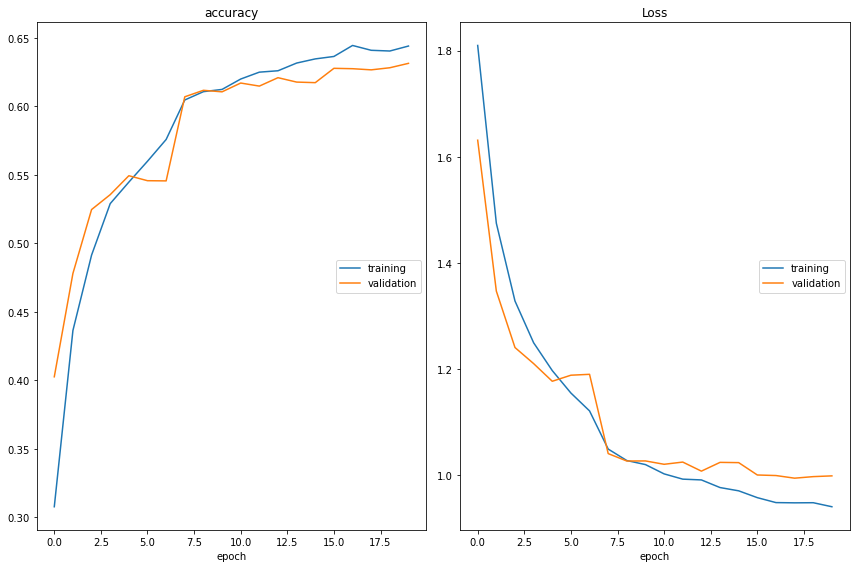

accuracy
	training         	 (min:    0.308, max:    0.644, cur:    0.644)
	validation       	 (min:    0.403, max:    0.631, cur:    0.631)
Loss
	training         	 (min:    0.941, max:    1.810, cur:    0.941)
	validation       	 (min:    0.995, max:    1.631, cur:    0.999)

Epoch 00020: saving model to classifier_weight.h5
448/448 [==============================] - 684s 2s/step - loss: 0.9411 - accuracy: 0.6441 - val_loss: 0.9992 - val_accuracy: 0.6314


In [13]:
#Entrainer et évaluer le modèle
epochs = 20
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size
checkpoint = ModelCheckpoint("classifier_weight.h5", monitor='val_accuracy', save_weights_only=True, mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001, mode='auto')

callbacks= [PlotLossesKeras(), checkpoint, reduce_lr]

history = classifier.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks
)

In [15]:
# Sauvégarder le modèle sous forme de fichier JSON
classifier_json = classifier.to_json()
with open("classifier.json","w") as json_file:
    json_file.write(classifier_json)

In [10]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.15
sesion = tf.compat.v1.Session(config=config)

class FacialExpressionClassifier(object):
    #EMOTION_LIST = ["Colère", "Dégoût", "Peur", "Joie", "Tristesse", "Suprise", "Neutre"]
    EMOTION_LIST = ["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Suprise"]
    def __init__(self, model_json_file, model_weights_file):
        with open(model_json_file, "r" ) as json_file:
            load_classifier = json_file.read()
            self.loaded_model = model_from_json(load_classifier)
        self.loaded_model.load_weights(model_weights_file)
        self.loaded_model.make_predict_function()

    def predict_emotion(self, img):
        self.preds = self.loaded_model.predict(img)
        return FacialExpressionClassifier.EMOTION_LIST[np.argmax(self)]

In [12]:
faceCascade = cv2.CascadeClassifier('./haarcascade_frontalface_default.xml')
classifier = FacialExpressionClassifier("classifier.json", "classifier_weight.h5")


video = cv2.VideoCapture(0)

while(True):
    # Capture frame-by-frame
    _, frame = video.read()
    # Our operations on the frame come here
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    #faces = faceCascade.detectMultiScale(gray, 1.3, 5)

    faces = faceCascade.detectMultiScale(gray, scaleFactor=1.2, minNeighbors=6, minSize=(60, 60),flags=cv2.CASCADE_SCALE_IMAGE)
    for (x, y, w, h) in faces:
        fc = gray[y:y+h, x:x+w]
        roi = cv2.resize(fc, (48, 48))
        pred = classifier.predict_emotion(roi[np.newaxis, :, :, np.newaxis])
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.rectangle(frame, (x-1, y-40),(x+w+1, y), (0, 255, 0), -1)
        cv2.putText(frame, pred, (x+10, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,255), 2)
        
    # Display the resulting frame
    cv2.imshow('frame', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
video.release()
cv2.destroyAllWindows()